## Logistic Regression

Классификация типа совпадения RFQ–Supplier (match, weak_match, related) на основе текстовых признаков (TF-IDF) и логистической регрессии.

---
## 1. Импорты и настройки


In [9]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

---
## 2. Загрузка данных

In [4]:
data_path = Path("../dataset/dataset_1k.csv")
df = pd.read_csv(data_path)

print("Форма датасета:", df.shape)
print("Колонки:", df.columns)

Форма датасета: (1000, 15)
Колонки: Index(['rfq_id', 'rfq_title', 'rfq_description', 'delivery_location',
       'quantity', 'rfq_supplier_types', 'supplier_name', 'supplier_country',
       'distribution_area', 'supplier_description', 'supplier_types',
       'products', 'product_categories', 'keywords', 'match_type'],
      dtype='object')


---
## 3. Предобработка

Очистка полей в формате PostgreSQL-массивов (фигурные скобки), подсчёт пропусков, заполнение пропусков в текстовых полях, формирование признаков `rfq_text` и `supplier_text`.

In [5]:
def clean_array_field(s: str) -> str:
    if pd.isna(s):
        return ""
   
    s = str(s).strip()
    if s.startswith("{") and s.endswith("}"):
        s = s[1:-1]

    return s.replace(",", ", ")

# Колонки в формате массива
array_columns = [
    "rfq_supplier_types", "supplier_types", "products", "product_categories", "keywords"
]
for col in array_columns:
    if col in df.columns:
        df[col] = df[col].apply(clean_array_field)

In [6]:
# Количество пропусков по колонкам до заполнения
nan_counts = df.isna().sum()
print("Пропуски по колонкам (до заполнения):")
for col in df.columns:
    if nan_counts[col] > 0:
        print(f"  {col}: {nan_counts[col]}")

Пропуски по колонкам (до заполнения):
  supplier_country: 1
  distribution_area: 271
  supplier_description: 345


In [7]:
# Заполняем пропуски в текстовых полях пустой строкой
text_columns = [
    "rfq_title", "rfq_description", "delivery_location", "quantity",
    "rfq_supplier_types", "supplier_name", "supplier_country", "distribution_area",
    "supplier_description", "supplier_types", "products", "product_categories", "keywords"
]
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna("").astype(str)

In [ ]:
# Текстовые признаки: rfq_text (RFQ), supplier_text (поставщик)
df["rfq_text"] = (
    df["rfq_title"].astype(str) + " "
    + df["rfq_description"].astype(str) + " "
    + df["delivery_location"].astype(str) + " "
    + df["quantity"].astype(str) + " "
    + df["rfq_supplier_types"].astype(str)
)
df["supplier_text"] = (
    df["supplier_name"].astype(str) + " "
    + df["supplier_description"].astype(str) + " "
    + df["products"].astype(str) + " "
    + df["product_categories"].astype(str) + " "
    + df["keywords"].astype(str) + " "
    + df["distribution_area"].astype(str) + " "
    + df["supplier_country"].astype(str) + " "
    + df["supplier_types"].astype(str)
)

df.head()

,rfq_id,rfq_title,rfq_description,delivery_location,quantity,rfq_supplier_types,supplier_name,supplier_country,distribution_area,supplier_description,supplier_types,products,product_categories,keywords,match_type,rfq_text,supplier_text
0,08c02539-9a51-453a-9072-060baddaa0bf,Schlüssel Anhänger für Hotels,"Guten Tag,\nFür unsere Kunde suchen wir Schlüs...","Pula, Kroatien",wird noch definiert mit Kunde,"WHOLESALER, PRODUCTION, DISTRIBUTION",Unique Elements GmbH,DE,europe,Wir sind Spezialisten für Schlüsselanhänger mi...,"Production, Service","Schutzengel / Engel Schlüsselanhänger, Einkauf...",Bekleidung & Accessoires,"Schlüsselanhänger, Schutzengel, Engel, Glücksb...",match,"Schlüssel Anhänger für Hotels Guten Tag,\nFü...",Unique Elements GmbH Wir sind Spezialisten für...
1,93c75bb7-1545-4279-aada-6d66b9c9e62e,elektrische Tretroller e-scooter,Neues Familienstartup; gesucht wird: e-scooter...,"Heilbronn, Deutschland",10,"PRODUCTION, WHOLESALER, DISTRIBUTION",Yatdim GmbH,DE,international,Yatdim GmbH – Ihr Partner für E‑Mobility‑Großh...,"Distribution, Production, Wholesaler",E-Bike BURCHDA RX80 fully suspended mountain b...,Vehicles,"Burchda RX80 Elektrofahrrad, E Mountainbike 26...",weak_match,elektrische Tretroller e-scooter Neues Familie...,Yatdim GmbH Yatdim GmbH – Ihr Partner für E‑Mo...
2,93c75bb7-1545-4279-aada-6d66b9c9e62e,elektrische Tretroller e-scooter,Neues Familienstartup; gesucht wird: e-scooter...,"Heilbronn, Deutschland",10,"PRODUCTION, WHOLESALER, DISTRIBUTION",Erler Mobile GmbH,DE,europe,Erler Mobile produziert Elektroroller und Elek...,"Production, Distribution, Wholesaler","Industrieroller COLLY 1, Industrieroller COLLY...",Fahrzeuge,"Industrieroller, Transportroller für Personen,...",related,elektrische Tretroller e-scooter Neues Familie...,Erler Mobile GmbH Erler Mobile produziert Elek...
3,93c75bb7-1545-4279-aada-6d66b9c9e62e,elektrische Tretroller e-scooter,Neues Familienstartup; gesucht wird: e-scooter...,"Heilbronn, Deutschland",10,"PRODUCTION, WHOLESALER, DISTRIBUTION",Yatdim GmbH,DE,international,Yatdim GmbH – Ihr Partner für E‑Mobility‑Großh...,"Wholesaler, Production, Distribution","""E-Bike Onesport OT16 Klappbares Elektrofahrra...",Fahrzeuge,"OneSport OT16 Elektrofahrrad, E Bike klappbar ...",related,elektrische Tretroller e-scooter Neues Familie...,Yatdim GmbH Yatdim GmbH – Ihr Partner für E‑Mo...
4,93c75bb7-1545-4279-aada-6d66b9c9e62e,elektrische Tretroller e-scooter,Neues Familienstartup; gesucht wird: e-scooter...,"Heilbronn, Deutschland",10,"PRODUCTION, WHOLESALER, DISTRIBUTION",HANDELSFABRIK SACHSEN GMBH,DE,,Kraftwerk E hat den Elektroroller Wandler K/E ...,Production,Escooter WANDLER-K/E - Electric scooter from W...,,"Motorroller, Escooter, Elektroroller",match,elektrische Tretroller e-scooter Neues Familie...,HANDELSFABRIK SACHSEN GMBH Kraftwerk E hat den...


---
## 4. Разбиение на обучающую, валидационную и тестовую выборки (60 / 20 / 20)

Используется **GroupShuffleSplit** по ключу `rfq_id`: все строки одного RFQ попадают в одну выборку. Сначала отделяем 60% групп в train и 40% во временную выборку; затем делим временную пополам — 20% validation, 20% test.

In [11]:
y = df["match_type"]
groups = df["rfq_id"]
feature_columns = ["rfq_text", "supplier_text"]

# 60% train, 40% временная выборка (будущие val + test)
gss1 = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=42)
train_idx, temp_idx = next(gss1.split(df, y, groups))

# Из 40% временной: половина validation, половина test (20% и 20% от всего)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=43)
val_idx, test_idx = next(gss2.split(df.iloc[temp_idx], y.iloc[temp_idx], groups.iloc[temp_idx]))
val_idx = np.array(temp_idx)[val_idx]
test_idx = np.array(temp_idx)[test_idx]

X_train = df.loc[train_idx, feature_columns]
y_train = y.iloc[train_idx]
X_val = df.loc[val_idx, feature_columns]
y_val = y.iloc[val_idx]
X_test = df.loc[test_idx, feature_columns]
y_test = y.iloc[test_idx]

print("Размер обучающей выборки (train):", len(X_train))
print("Размер валидационной выборки (validation):", len(X_val))
print("Размер тестовой выборки (test):", len(X_test))

Размер обучающей выборки (train): 646
Размер валидационной выборки (validation): 141
Размер тестовой выборки (test): 213


---
## 5. Модель и обучение

Конвейер: **ColumnTransformer** с двумя **TfidfVectorizer** (по `rfq_text` и `supplier_text`) и **LogisticRegression** с `class_weight='balanced'` для учёта дисбаланса классов.

In [12]:
column_transformer = ColumnTransformer(
    [
        ("rfq_tfidf", TfidfVectorizer(), "rfq_text"),
        ("supplier_tfidf", TfidfVectorizer(), "supplier_text"),
    ],
    remainder="drop",
)

pipeline = Pipeline([
    ("features", column_transformer),
    ("clf", LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")),
])

pipeline.fit(X_train, y_train)

# Предсказания: на validation (для подбора гиперпараметров) и на test (финальная оценка)
y_pred_val = pipeline.predict(X_val)
y_pred = pipeline.predict(X_test)

---
## 6. Оценка качества и визуализация

In [14]:
print("Validation (accuracy):", round(accuracy_score(y_val, y_pred_val), 4))
print()
print("Test — classification report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Test — accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nConfusion matrix (test):")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Validation (accuracy): 0.3972

Test — classification report:
              precision    recall  f1-score   support

       match       0.73      0.81      0.76       159
     related       0.00      0.00      0.00        21
  weak_match       0.13      0.09      0.11        33

    accuracy                           0.62       213
   macro avg       0.29      0.30      0.29       213
weighted avg       0.56      0.62      0.59       213

Test — accuracy: 0.615

Confusion matrix (test):
[[128  13  18]
 [ 19   0   2]
 [ 29   1   3]]


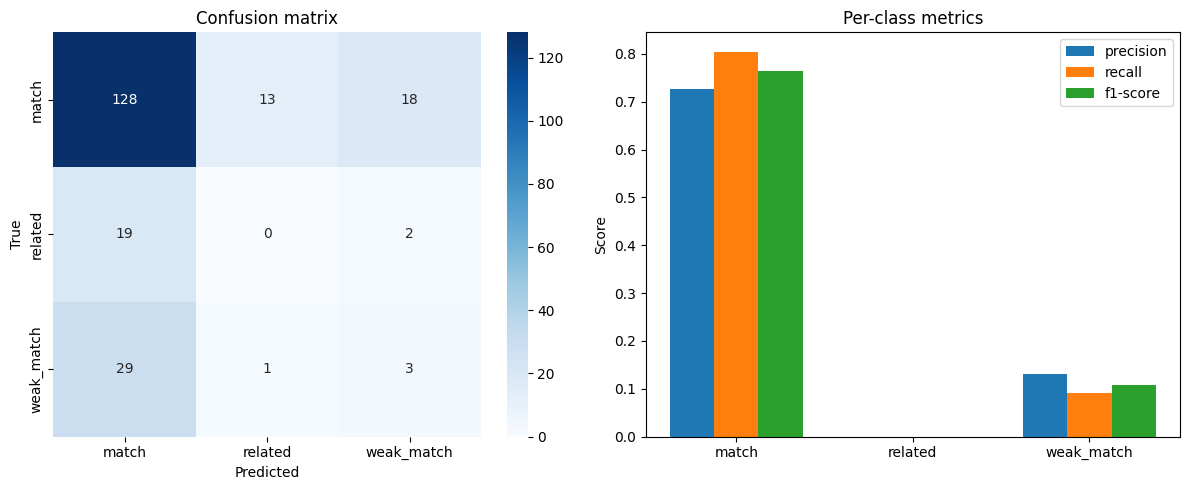

In [15]:
labels = sorted(y.unique())
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Матрица ошибок
sns.heatmap(
    cm, xticklabels=labels, yticklabels=labels, annot=True, fmt="d",
    cmap="Blues", ax=axes[0]
)
axes[0].set_title("Confusion matrix")
axes[0].set_ylabel("True")
axes[0].set_xlabel("Predicted")

# Метрики по классам
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
metrics = ["precision", "recall", "f1-score"]
x = np.arange(len(labels))
width = 0.25
for i, m in enumerate(metrics):
    vals = [report[l].get(m, 0) for l in labels]
    axes[1].bar(x + i * width, vals, width, label=m)
    
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(labels)
axes[1].set_ylabel("Score")
axes[1].set_title("Per-class metrics")
axes[1].legend()

plt.tight_layout()
plt.show()

## Выводы

**Validation accuracy: 39.72%** - модель угадывает класс только в 40% случаев (возможно это связано с маленкой выборкой было взято только 1000 записей).

На тесте 62%.
На тестовой выборке модель "хорошо" предсказывает тип match, среди всех предсказаний match доля верных 73%.
Класс доминирует в данных и предсказывается лучше всего.

Модель не предсказывает related: класс «потерян».

Очень слабо также для weak_match: только 9% реальных weak_match распознаны, и только 13% предсказаний weak_match верны. Класс почти не учится.

Модель по сути предсказывает в основном «match» и иногда «weak_match», класс related не выделяет.
Это типично при сильном дисбалансе (много match, мало related/weak_match) и том, что текстовые признаки для related/weak_match слабо отличаются от match. Возможно следует использовать бинарную классификацию, где match + weak_match + related = match, а no_match (отсутсвует в текущем датасете).

Чтобы улучшить related и weak_match, можно: усилить веса меньших классов (class_weight), или увеличить данные по этим классам или добавить признаки (например, категориальные).